# Clustering 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import plotly
import plotly.graph_objs as go

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Data Preparation
Here is the the dataset from Autoscout24. We reuse the steps that we developed in the regression exercise to read and clean the data:

In [3]:
df = pd.read_csv("cars.csv")
df['Age'] = df.Year-1984
df.drop(['Color', 'Name', 'Registration', 'Year'], axis='columns', inplace=True)
df.drop_duplicates(inplace=True)
df.drop([17010, 7734, 47002, 44369, 24720, 50574, 36542, 42611,
         22513, 12773, 21501, 2424, 52910, 29735, 43004, 47125], axis='rows', inplace=True)
df.drop(df.index[df.EngineSize > 7500], axis='rows', inplace=True)

Above reads the data, removes unneeded columns and some outliers. All categorical variables have been removed for this exercise.

In [4]:
df.head()

Price  Mileage  Doors  Horsepower  EngineSize  Seats  Cylinders  Gears  \
0   44800    27600      2         320        4973      2          8      5   
1   22800    18300      4         286        4398      5          8      5   
2  183710      650      5         350        4172      5          8      6   
3   19900    32000      5         150        2198      7          4      6   
4   18999   118000      5         163        2401      5          5      5   

   Age  
0   12  
1   15  
2   24  
3   22  
4   19

In [38]:
df.describe()

Price       Mileage         Doors    Horsepower    EngineSize  \
count   53843.000000   53843.00000  53843.000000  53843.000000  53843.000000   
mean    29736.330999   53678.33360      4.336980    171.828947   2120.123526   
std     30550.497496   59523.69491      1.048416     93.304944    961.810195   
min       300.000000       0.00000      2.000000     40.000000    599.000000   
25%     11938.500000    2000.00000      4.000000    113.000000   1560.000000   
50%     21900.000000   31000.00000      5.000000    150.000000   1968.000000   
75%     36900.000000   90500.00000      5.000000    200.000000   2324.000000   
max    489000.000000  450000.00000      5.000000    736.000000   7011.000000   

              Seats     Cylinders         Gears           Age  
count  53843.000000  53843.000000  53843.000000  53843.000000  
mean       4.805119      4.567056      5.796074     24.627862  
std        0.911667      1.369624      0.857852      4.406785  
min        2.000000      2.000000      3.000000      1.000000  
25%        5.000000      4.000000      5.000000     22.000000  
50%        5.000000      4.000000      6.000000     26.000000  
75%        5.000000      4.000000      6.000000     28.000000  
max        9.000000     12.000000      8.000000     30.000000

## K-Means Clustering
We want to find out if we can group the cars somehow, in order to better understand what kind of cars are offered on the platform.

First let us create the training set X.

In [5]:
X = df.values

> Appy the [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) estimator from Scikit-Learn to cluster the X. Create three clusters and set the `random_state` to 0.

In [6]:
est = KMeans(n_clusters=3, random_state=0).fit(X)

The clusters that K-Means assigns to each sample can be found in `est.labels_`

In [7]:
labels = est.labels_
labels[0:10]

array([2, 2, 2, 2, 0, 0, 0, 1, 0, 0])

Let's plot the clusters. Without dimensionality reduction, we can only plot three dimensions at one time. We start by plotting *Mileage*, *Horsepower* and *Age* on the axes and the assigned cluster as the color.

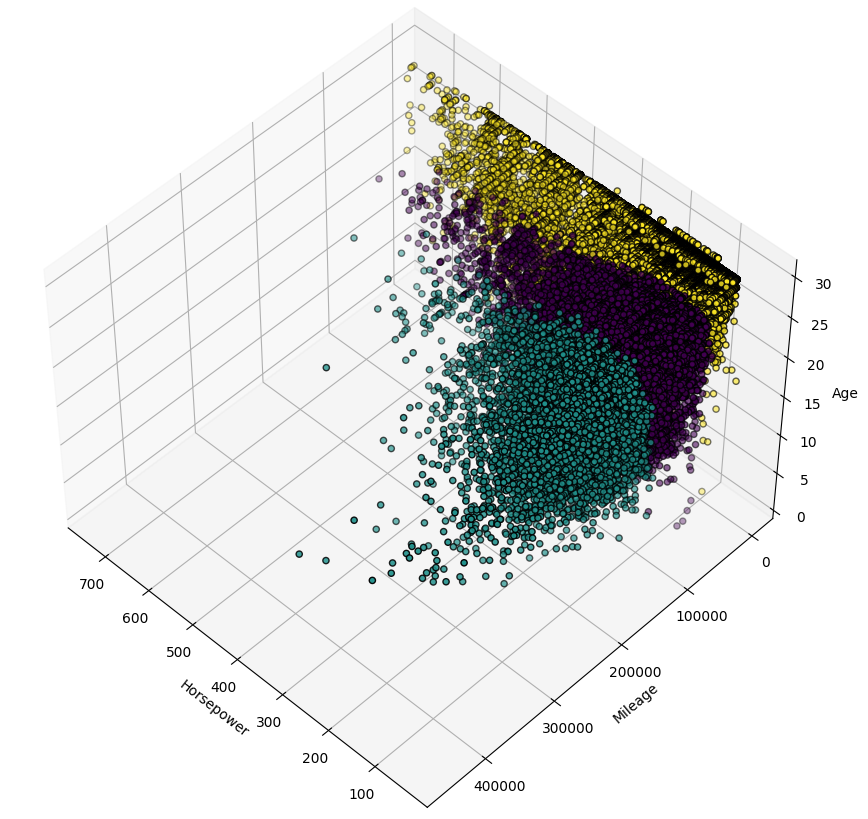

In [8]:
fig = plt.figure(1, figsize=(10, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(xs = X[:, 3], ys = X[:, 1], zs = X[:, 8], c=labels.astype(np.float), edgecolor='k')
ax.set_xlabel('Horsepower'); 
ax.set_ylabel('Mileage'); 
ax.set_zlabel('Age')
fig.show()

*Click on the dots to display the solution*

We forgot to scale the dataset. K-Means, like other distance- or similarity based algorithms, is impacted by the scale of the features.

We fix this and rerun the plotting. We want to keep the original X so we can plot the dots in the original scale.

In [9]:
scaler = RobustScaler()
X_transformed = scaler.fit_transform(X)
est = KMeans(n_clusters=3, random_state=0).fit(X_transformed)
labels = est.labels_

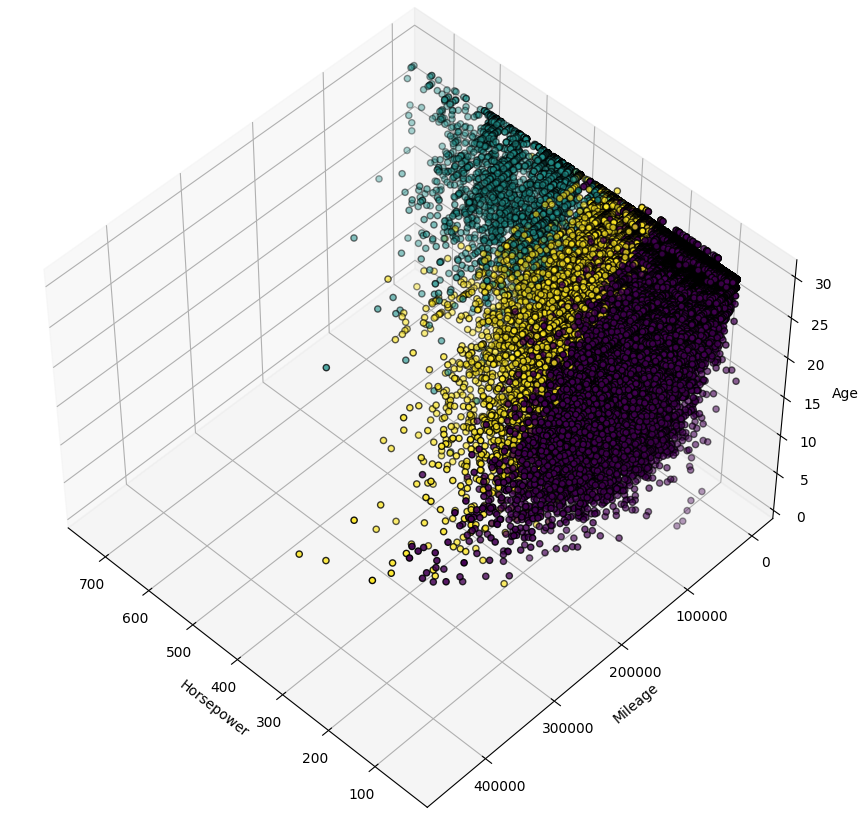

In [10]:
fig = plt.figure(1, figsize=(10, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(xs = X[:, 3], ys = X[:, 1], zs = X[:, 8], c=labels.astype(np.float), edgecolor='k')
ax.set_xlabel('Horsepower'); 
ax.set_ylabel('Mileage'); 
ax.set_zlabel('Age')
fig.show()

Now the separation is a bit less clear and shifted towards Horsepower. We will look at this in a more visible way a bit later.

#### Cluster centers
The cluster centers can be found in 

In [11]:
est.cluster_centers_

array([[ 0.04266739,  0.2072752 , -0.52749865, -0.15947454, -0.31944267,
        -0.10241687, -0.02873414, -0.29181277, -0.14632214],
       [ 3.65505184, -0.01571764, -2.13498723,  3.58054993,  3.89089376,
        -1.46296972,  4.59759212,  0.37030281, -0.28183145],
       [ 0.5891197 ,  0.58458969, -0.86328261,  1.21638675,  1.58323415,
        -0.24753165,  2.22453247,  0.04704379, -0.61832578]])

However, these are the transformed cluster centers, if we want to examine or plot them, we need to unscale them (since we have not scaled X).

In [12]:
centers = scaler.inverse_transform(est.cluster_centers_)
centers

array([[2.29650420e+04, 4.93438553e+04, 4.47250135e+00, 1.36125715e+02,
        1.72394580e+03, 4.89758313e+00, 3.97126586e+00, 5.70818723e+00,
        2.51220672e+01],
       [1.13135576e+05, 2.96089887e+04, 2.86501277e+00, 4.61507844e+02,
        4.94064283e+03, 3.53703028e+00, 8.59759212e+00, 6.37030281e+00,
        2.43090113e+01],
       [3.66053113e+04, 8.27361872e+04, 4.13671739e+00, 2.55825648e+02,
        3.17759089e+03, 4.75246835e+00, 6.22453247e+00, 6.04704379e+00,
        2.22900453e+01]])

#### Assign a data point to a cluster
We can pick a random point and calculate the distances to all cluster centers. 

The first step is to normalize our sample datapoint.

In [13]:
centers = est.cluster_centers_

x_sample = scaler.transform([X[16]])

> Calculate the three [euclidean distances](https://en.wikipedia.org/wiki/Euclidean_distance) of point `x_sample` to the cluster centers.

In [18]:
distances = []
for i in range(len(centers)):
    dist = np.sqrt(np.sum(np.square(x_sample - centers[i])))
    # dist = np.linalg.norm(x_sample - centers[i]) # this works as well
    distances.append(dist)
    print("Distance to center of cluster {} is {}.".format(i, dist))
y_pred = np.argmin(distances)
print("Datapoint is assigned to cluster", y_pred)

Distance to center of cluster 0 is 0.910637121020724.
Distance to center of cluster 1 is 8.076932095595003.
Distance to center of cluster 2 is 3.161392315284473.
Datapoint is assigned to cluster 0


We can check if our code is correct by accessing the `labels_` attribute of the estimator.

In [49]:
est.labels_[16]

0

We could also use the `predict` function

In [50]:
est.predict(x_sample)

array([0])

## Find the optimal number of clusters
We used 3 clusters above, which was a random guess. To find the optimal number of clusters, we have seen the *Elbow Method* in the lecture. Our estimator has the distortions in the `est.inertia_` property. 

> Calculate K-Means for 1 to 20 clusters and store the distortion for each. Use the seed value 0.

In [51]:
distortions = []
for i in tqdm(range(1, 21)):
    est = KMeans(n_clusters=i, random_state=0).fit(X_transformed)
    distortions.append(est.inertia_)

  0%|          | 0/20 [00:00<?, ?it/s]

Let's put that in a dataframe and plot it.

<AxesSubplot:xlabel='x'>

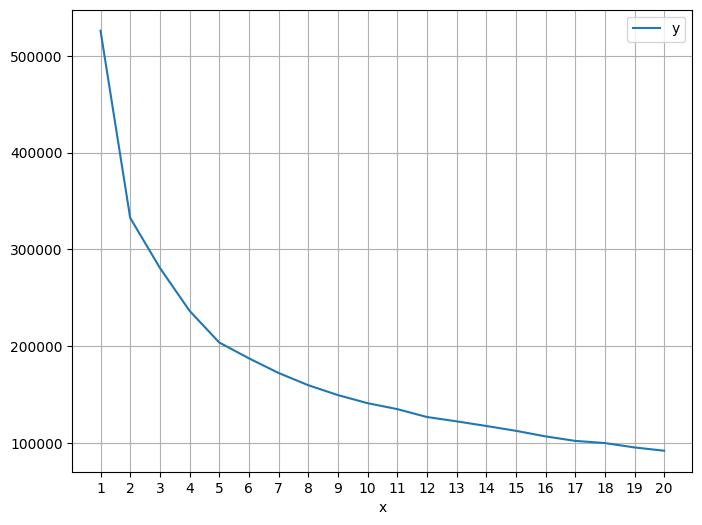

In [52]:
pd.DataFrame(dict(x=range(1, 21), y=distortions)).plot(x="x", y="y", xticks=range(1, 21), grid=True, figsize=(8,6))

> Using the elbow rule, what is the optimal number of clusters for our dataset?

In [53]:
n_clusters = 5

## Plot the results
Now that we have our optimal settings, we plot our result, including the cluster centers, in an interactive plot so you can change the view and examine the clusters a bit.

In [54]:
est = KMeans(n_clusters=n_clusters, random_state=0).fit(X_transformed)
centers = scaler.inverse_transform(est.cluster_centers_)

plotly.offline.init_notebook_mode(connected=True)

axes = dict(x='Mileage', y='Horsepower', z='Age')
x, y, z = X[:, 1], X[:, 3], X[:, 8]

# taken from https://plot.ly/ipython-notebooks/color-scales/#colorlover
# change plotting code below if you need more than 5 colors
color_scale5  = ['rgb(127,201,127)', 'rgb(190,174,212)', 'rgb(253,192,134)', 'rgb(255,255,153)', 'rgb(56,108,176)']
color_scale10 = ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)',
                'rgb(253,180,98)', 'rgb(179,222,105)', 'rgb(252,205,229)', 'rgb(217,217,217)', 'rgb(188,128,189)']

points = go.Scatter3d(x=x, y=y ,z=z, mode='markers',
    marker=dict(size=1, opacity=0.8,line=dict(color=[color_scale5[i] for i in est.labels_], width=0.5)))
centers = go.Scatter3d(x=centers[:, 1], y=centers[:, 3] ,z=centers[:, 8], mode='markers',
    marker=dict(size=8, line=dict(color='rgb(255,0,0)', width=1.0)))

layout = go.Layout(
    scene=dict( xaxis=dict(title=axes['x']), yaxis=dict(title=axes['y']), zaxis=dict(title=axes['z'])),
    margin=dict(l=0, r=0, b=0, t=0))

fig = go.Figure(data=[points, centers], layout=layout)
plotly.offline.iplot(fig)

## Only for Information: Overview of clustering algorithms

We have seen the K-Means algorithm in class, which is arguably the most famous clustering algorithms. It works well with a high sample-count and enjoys very diverse applications. But there are many different clustering algorithms, K-Means is just one of them. The following overview, taken straight from [Scikit-Learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py) examples, shows a nice overview over different algorithms.

  0%|          | 0/6 [00:00<?, ?it/s]

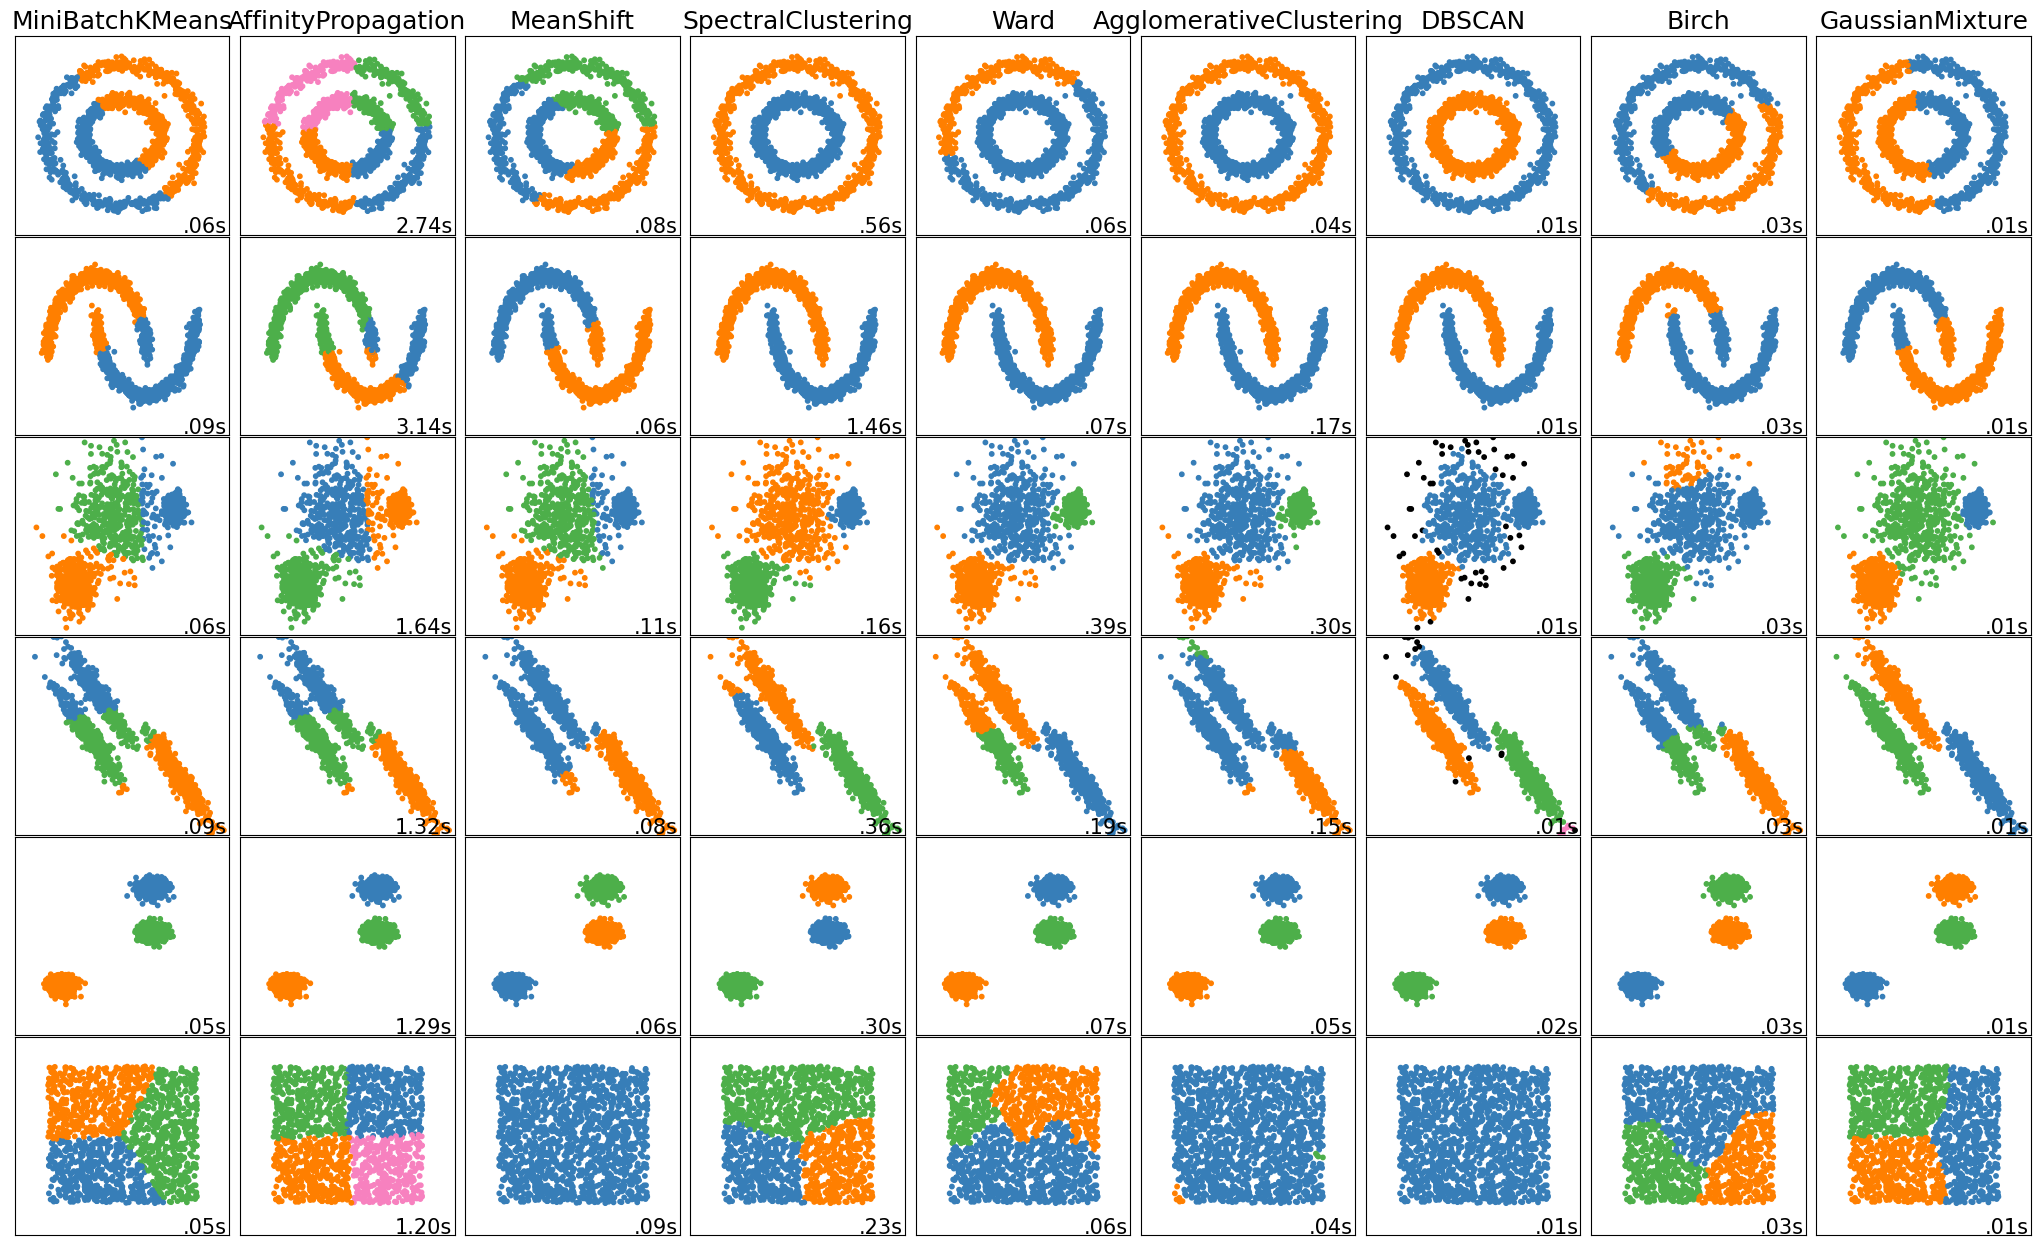

In [55]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240, 'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(tqdm(datasets)):
    
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'], include_self=False)
    
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward',connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack',affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(linkage="average", affinity="cityblock",n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']), int(max(y_pred) + 1))))
        
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'), transform=plt.gca().transAxes, size=15, horizontalalignment='right')
        plot_num += 1

plt.show()

## Assignment
> Before continuing with the second exercise, answer the question on the ILIAS quiz  **Clustering**.

In [56]:
est = KMeans(n_clusters=5, random_state=0).fit(X_transformed)

> Given a KMeans model that was trained on our dataset with 5 clusters. Calculate the euclidean distance of the following car to each of the cluster centers. What is the euclidean distance to the nearest cluster center?
* Price = 45000
* Mileage = 20000
* Doors = 5
* Horsepower = 120
* Engine size = 5000
* Seats = 5
* Cylinders = 8
* Gears = 5
* Age = 10

In [28]:
car = np.array([45000, 20000, 5, 120, 5000, 5, 8, 5, 10])
car_transformed = scaler.transform([car])

distances = []
for cluster_center in est.cluster_centers_: 
    dist = np.linalg.norm(car_transformed - cluster_center)
    distances.append(dist)

print(distances)
print(np.argmin(distances))

[6.533288354221043, 6.123561987294138, 4.241901396756296]
2
